In [2]:
# Import data, Define Classes, Subclasses and respective Points
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import ee
import os
import random
import math
import geemap
m = geemap.core.Map()
ee.Authenticate()
ee.Initialize()

crudeBorders = ee.Geometry.Polygon(
        [[[-70.07663362002641, 12.642409005331041],
          [-70.08350007510454, 12.528484055387077],
          [-69.95303742862016, 12.419873412682719],
          [-69.85416047549516, 12.389025068780875],
          [-69.84111421084673, 12.40109659488839],
          [-69.86240022158891, 12.486251996961656],
          [-70.05466096377641, 12.641069006200203]]])

classNames = ['Permanent_Water', 'Mangrove', 'Herbaceous_Wetland', 'Tree_Cover', 'Shrubland', 'Sparse', 'Build_Environment']
subClassNames = ['Sea', 'Mangrove', 'Dam_Tanki', 'Salina', 'Wetland_Other', 'Cactus_Dominated', 'Decidious_Dominated', 'Evergreen_Dominated', 
              'Shrubland', 'Quarry', 'Degraded_Land', 'Sandcoast', 'Rockcoast', 'Rockformations', 'Dead_Mangrove', 'Road', 'Building', 'Sportfield']

classDict = { item: i for i, item in enumerate(classNames)}
subClassDict = { item: i for i, item in enumerate(subClassNames)}
reverse_classDict = {value: key for key, value in classDict.items()}
reverse_subClassDict = {value: key for key, value in subClassDict.items()}
landcoverOffset = {'Herbaceous_Wetland': 2, 'Tree_Cover': 5, 'Sparse': 9, 'Build_Environment': 15}

classesFromSubClasses = {
    'Permanent_Water': [0],
    'Mangrove': [1],
    'Herbaceous_Wetland': [2,3,4],
    'Tree_Cover': [5,6], # should also have 7, but it having 1 point is anoying, so it was removed before this.
    'Shrubland': [8],
    'Sparse': [9, 10, 11, 12, 13, 14],
    'Build_Environment': [15, 16, 17] # sportfields in build environment is a point of tension
}

classPoints = eval(open('./output/classPoints.txt', 'r').read())
subClassPoints = eval(open('./output/subClassPoints.txt', 'r').read())

def getImageBandsRes(start, end, roi, clip, cloudLess):
    # Dates are python dates
    # n.b. start can belong to one regime and end to another, this might cause problems.   
    date_format = "%Y-%m-%d"
    if start < datetime.strptime("1985-01-01", date_format):
        print('no satellite currently available')
        return
    elif start < datetime.strptime("2000-01-01", date_format):
        collection = ee.ImageCollection("LANDSAT/LT05/C02/T1").filterBounds(roi).filterDate(start, end)
        collection = collection.map(lambda image: 
            image.set(image.toDictionary().combine({'contains_roi': image.geometry().contains(roi)})) \
        ).filter(ee.Filter.eq('contains_roi', True))
        if cloudLess:
            image = ee.Algorithms.Landsat.simpleComposite(collection, asFloat=True)
        else: 
            image = ee.Algorithms.Landsat.TOA(collection.sort('CLOUD_COVER_LAND').first())
        bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']
        res = 30
    elif start < datetime.strptime("2014-01-01", date_format):
        collection =  ee.ImageCollection("LANDSAT/LE07/C02/T1").filterBounds(roi).filterDate(start, end)
        collection = collection.map(lambda image: 
            image.set(image.toDictionary().combine({'contains_roi': image.geometry().contains(roi)})) \
        ).filter(ee.Filter.eq('contains_roi', True))
        if cloudLess:
            image = ee.Algorithms.Landsat.simpleComposite(collection, asFloat=True)
        else: 
            image = ee.Algorithms.Landsat.TOA(collection.sort('CLOUD_COVER_LAND').first())
        bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']
        res = 30
    elif start < datetime.strptime("2023-01-01", date_format):
        collection = ee.ImageCollection("LANDSAT/LC08/C02/T1").filterBounds(roi).filterDate(start, end)
        collection = collection.map(lambda image: 
            image.set(image.toDictionary().combine({'contains_roi': image.geometry().contains(roi)})) \
        ).filter(ee.Filter.eq('contains_roi', True))
        if cloudLess:
            image = ee.Algorithms.Landsat.simpleComposite(collection, asFloat=True)
        else: 
            image = ee.Algorithms.Landsat.TOA(collection.sort('CLOUD_COVER_LAND').first())
        bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
        res = 30
    else:
        collection = ee.ImageCollection("LANDSAT/LC09/C02/T1").filterBounds(roi).filterDate(start, end)
        collection = collection.map(lambda image: 
            image.set(image.toDictionary().combine({'contains_roi': image.geometry().contains(roi)})) \
        ).filter(ee.Filter.eq('contains_roi', True))
        if cloudLess:
            image = ee.Algorithms.Landsat.simpleComposite(collection, asFloat=True)
        else: 
            image = ee.Algorithms.Landsat.TOA(collection.sort('CLOUD_COVER_LAND').first())
        bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
        res = 30
    
    ndvi = image.normalizedDifference([bands[3], bands[2]]).rename('NDVI')
    ndbi = image.normalizedDifference([bands[4], bands[3]]).rename('NDBI')
    ndwi = image.normalizedDifference([bands[1], bands[3]]).rename('NDWI')
    bsi = image.expression(
        '((SWIR + RED) - (NIR + BLUE)) / ((SWIR + RED) + (NIR + BLUE))', {
        'SWIR': image.select(bands[4]),
        'RED': image.select(bands[2]),
        'NIR': image.select(bands[3]),
        'BLUE': image.select(bands[0])
        }).rename('BSI')
    
    image = image.addBands([ndvi, ndbi, ndwi, bsi])
    bands += ['NDVI', 'NDBI', 'NDWI', 'BSI']

    if clip: image = image.clip(roi)
    
    return image, bands, res


classNames = ['Permanent_Water', 'Mangrove', 'Herbaceous_Wetland', 'Tree_Cover', 'Shrubland', 'Sparse', 'Build_Environment']
subClassNames = ['Sea', 'Mangrove', 'Dam_Tanki', 'Salina', 'Wetland_Other', 'Cactus_Dominated', 'Decidious_Dominated', 'Evergreen_Dominated', 
              'Shrubland', 'Quarry', 'Degraded_Land', 'Sandcoast', 'Rockcoast', 'Rockformations', 'Dead_Mangrove', 'Road', 'Building', 'Sportfield']

# ML constants
classPalette = [
  '#0000FF', # Permanent Water: Blue
  '#ff0cf6', # Mangroves: Purple
  '#00FF00', # Herbaceous wetland: Bright Green
  '#008000', # Tree Cover: Dark Green
  '#A52A2A', # Shrubland: Brown
  '#FFFF00', # Bare or sparse vegetation: Yellow
  '#808080', # Built environment: Grey
  '#000000', # No data: Black 
]

classVis = {
  'min': 0,
  'max': 6,
  'palette': classPalette
}

subClassPalette = [
    '0000FF', # Permanent Water: Blue
    'ff0cf6', # Mangroves: Purple
    '99ccff',  # Dam/Tanki: Light Blue
    'cce6ff',  # Salina: Very Light Blue
    '66ff66',  # Wetland_Other: Lighter Bright Green
    'd2b48c',  # Cactus_Dominated: Tan
    '66cc66',  # Deciduous_Dominated: Lighter Dark Green
    '005700',  # Evergreen_Dominated: Darker Dark Green
    'A52A2A', # Shrubland: Brown
    'ffffcc',  # Quarry: Light Yellow
    'cccc00',  # Degraded_Land: Dark Yellow
    'fff5cc',  # Sandcoast: Pale Yellow
    'ffffe6',  # Rockcoast: Greyish Yellow
    'f5f5dc',  # Rockformations: Beige
    'e6cce6',  # Dead Mangrove: Desaturated Purple
    '707070',  # Road: Lighter Dark Grey
    'd9d9d9',  # Building: Light Grey
    'bfbfbf'   # Sportfield: Medium Grey
]

# This cannot be defined before the getImageAndBands is executed
regVis = {
  'min': 0.0,
  'max': 0.6,
  "bands": ['B4', 'B3', 'B2'],
}

ml_methods = {'libsvm': [f'kernelType={type}' for type in ['"LINEAR"', '"RBF"']],
              'smileKNN': [f'k={i}' for i in [1,3,5,7]], 
              'smileRandomForest': [10,20,30,40,50], 
              'smileGradientTreeBoost':[10,20,30,40,50], 
              'smileCart': [''], 
              }

mlNames = [f'ee.Classifier.{key}({param})' for key, value in ml_methods.items() for param in value]


In [ ]:
# Investigate which satellite for which dates & cloud removal.
from datetime import datetime
m = geemap.Map()

# For which dates do you want to do this? 
# 1985, 1995, and the first and second halve of 2015.
# second and fourth quarter of 2016 and 2023

# Years for which there are 0 images: 1992
year = 1988
try:
    image, bands, res = getImageBandsRes(datetime.strptime(f'{year}-01-01', "%Y-%m-%d"), 
                                         datetime.strptime(f'{year+1}-01-01', "%Y-%m-%d"), 
                                         crudeBorders, 
                                         False, 
                                         True)
    image.getInfo()
except:
    print('no images available.')


print(bands)
sBands = bands[2], bands[1], bands[0]  # Assuming these are RGB bands for Landsat

vis = {'bands': sBands, 'min': 0, 'max': 0.6}
m.addLayer(image, vis, 'composite image')
m.centerObject(crudeBorders, 11)

m


In [14]:
# Computing RS 
from datetime import datetime
from dateutil.relativedelta import relativedelta
startDate = datetime.strptime('1985-01-01', "%Y-%m-%d")
endDate = startDate + relativedelta(years=1)

images = []

while endDate < datetime.strptime('2025-02-01', "%Y-%m-%d"):
    nonEmpty = True
    # Get cloud free image for the current month
    try:
        cloudFree, bands, res = getImageBandsRes(startDate, endDate, crudeBorders, True, True) 
        cloudFree.getInfo()
    except:
        nonEmpty = False
    if nonEmpty:
        images.append(cloudFree)
        
    startDate = endDate 
    endDate += relativedelta(years=1)


In [15]:
# Exporting Resulting images to Google Earth Engine:
import datetime
dates = eval(open('./output/dates.txt', 'r').read())
for i, image in enumerate(images):
    selectedDate = dates[i].strftime('%Y-%m')
    task = ee.batch.Export.image.toAsset(
        image=image,
        description='image_export',
        assetId=f'projects/aruba-tdf/assets/images/{selectedDate}',  
        scale=30,
        crs='EPSG:4326'
    )
    task.start()

In [6]:
# Visualizing training and validation points
m = geemap.Map()
image, bands, res = getImageBandsRes(datetime.strptime(f'2023-01-01', "%Y-%m-%d"), datetime.strptime(f'2023-12-31', "%Y-%m-%d"), crudeBorders, False, True)
vis = {'bands': [bands[2], bands[1], bands[0]], 'min': 0, 'max': 0.6}
m.addLayer(image, vis, 'composite image')
i = 6
m.addLayer(ee.FeatureCollection(classPoints[classNames[i]]['training']), {'color': classPalette[i], 'pointSize': 5})
m.addLayer(ee.FeatureCollection(classPoints[classNames[i]]['validation']), {'color': classPalette[i], 'pointSize': 5})
m.centerObject(crudeBorders, 11)
m

Map(center=[12.508181861211431, -69.97108964342154], controls=(WidgetControl(options=['position', 'transparent…

In [4]:
# Testing and showing structure of above
print(subClassPoints['Sea']['training'])
print(classPoints['Permanent_Water']['validation'])

for key, value in subClassPoints.items():
    print(key, len(value['training']['features']))
    print(key, len(value['validation']['features']))

for key, value in classPoints.items():
    print(key, value['training']['features'])
    print(key, len(value['validation']['features']))

{'type': 'FeatureCollection', 'columns': {'landcover': 'Integer', 'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-69.9628151123782, 12.546472139466623]}, 'id': '2_31', 'properties': {'landcover': 0}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-69.95740777900417, 12.544628949480812]}, 'id': '2_34', 'properties': {'landcover': 0}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-70.0192767615108, 12.483490383546572]}, 'id': '2_2', 'properties': {'landcover': 0}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-69.95621863951223, 12.436817957700612]}, 'id': '2_39', 'properties': {'landcover': 0}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-69.98489909246021, 12.568733162429382]}, 'id': '2_22', 'properties': {'landcover': 0}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-70.03404170081657, 12.49643497276697]}, 'id': '2_6', 'p

In [15]:
# Calculate error classes
from datetime import datetime
from dateutil.relativedelta import relativedelta

training_points = ee.FeatureCollection([])
validation_points = ee.FeatureCollection([])
for value in classPoints.values():
    training_points = training_points.merge(value['training'])
    validation_points = validation_points.merge(value['validation'])



accuracy = {name: [] for name in mlNames}
# Do until 2016 once every year, after that once every 1/2 year.


startDate = datetime.strptime('1985-01-01', "%Y-%m-%d")
endDate = startDate + relativedelta(years=1)

dates = []
while endDate < datetime.strptime('2025-02-01', "%Y-%m-%d"):
  nonEmpty = True
  # Get cloud free image for the current month
  try:
    cloudFree, bands, res = getImageBandsRes(startDate, endDate, crudeBorders, True, True) 
    cloudFree.getInfo()
  except:
    nonEmpty = False
  if nonEmpty:
    # Overlay the points on the imagery to get bands for each point
    training = cloudFree.select(bands).sampleRegions(
        collection=training_points,
        properties=['landcover'],
        scale=res
    )
    validation = cloudFree.select(bands).sampleRegions(
        collection=validation_points,
        properties=['landcover'],
        scale=res
    )
    dates.append(startDate + (endDate - startDate)/2)
    for method in mlNames:
      classifier = eval(method)
      # Machine Learning: Classifier training and classification
      trainedClassifier = classifier.train(training, 'landcover', bands)
      classified = cloudFree.select(bands).classify(trainedClassifier)
      
      validated = validation.classify(trainedClassifier)
      confusionMatrix = validated.errorMatrix('landcover', 'classification')
      acc = confusionMatrix.accuracy()
      accuracy[method].append(acc.getInfo())

      print(startDate, method, acc.getInfo())

  
  startDate = endDate 
  endDate += relativedelta(years=1)

print(dates)
print(accuracy)

1985-01-01 00:00:00 ee.Classifier.libsvm(kernelType="LINEAR") 0.5285714285714286
1985-01-01 00:00:00 ee.Classifier.libsvm(kernelType="RBF") 0.4857142857142857
1985-01-01 00:00:00 ee.Classifier.smileKNN(k=1) 0.9642857142857143
1985-01-01 00:00:00 ee.Classifier.smileKNN(k=3) 0.7357142857142858
1985-01-01 00:00:00 ee.Classifier.smileKNN(k=5) 0.7071428571428572
1985-01-01 00:00:00 ee.Classifier.smileKNN(k=7) 0.6428571428571429
1985-01-01 00:00:00 ee.Classifier.smileRandomForest(10) 0.9214285714285714
1985-01-01 00:00:00 ee.Classifier.smileRandomForest(20) 0.95
1985-01-01 00:00:00 ee.Classifier.smileRandomForest(30) 0.9642857142857143
1985-01-01 00:00:00 ee.Classifier.smileRandomForest(40) 0.9642857142857143
1985-01-01 00:00:00 ee.Classifier.smileRandomForest(50) 0.9571428571428572
1985-01-01 00:00:00 ee.Classifier.smileGradientTreeBoost(10) 0.8714285714285714
1985-01-01 00:00:00 ee.Classifier.smileGradientTreeBoost(20) 0.8928571428571429
1985-01-01 00:00:00 ee.Classifier.smileGradientTreeB

Support Vector Machine (Linear kernel) 0.5399613899613899
Support Vector Machine (RBF kernel) 0.5034749034749035
K-Nearest Neighbours (1 neighbour) 0.9758687258687262
K-Nearest Neighbours (3 neighbours) 0.7654440154440154
K-Nearest Neighbours (5 neighbours) 0.7036679536679536
K-Nearest Neighbours (7 neighbours) 0.6588803088803089
Random Forests (10 trees) 0.9245173745173745
Random Forests (20 trees) 0.9501930501930502
Random Forests (30 trees) 0.9590733590733591
Random Forests (40 trees) 0.9642857142857143
Random Forests (50 trees) 0.9658301158301157
Gradient Boosted Decision Trees (10 trees) 0.8872586872586873
Gradient Boosted Decision Trees (20 trees) 0.9044401544401545
Gradient Boosted Decision Trees (30 trees) 0.9069498069498068
Gradient Boosted Decision Trees (40 trees) 0.9133204633204631
Gradient Boosted Decision Trees (50 trees) 0.9171814671814671
Classification and Regression Trees 0.9725868725868725


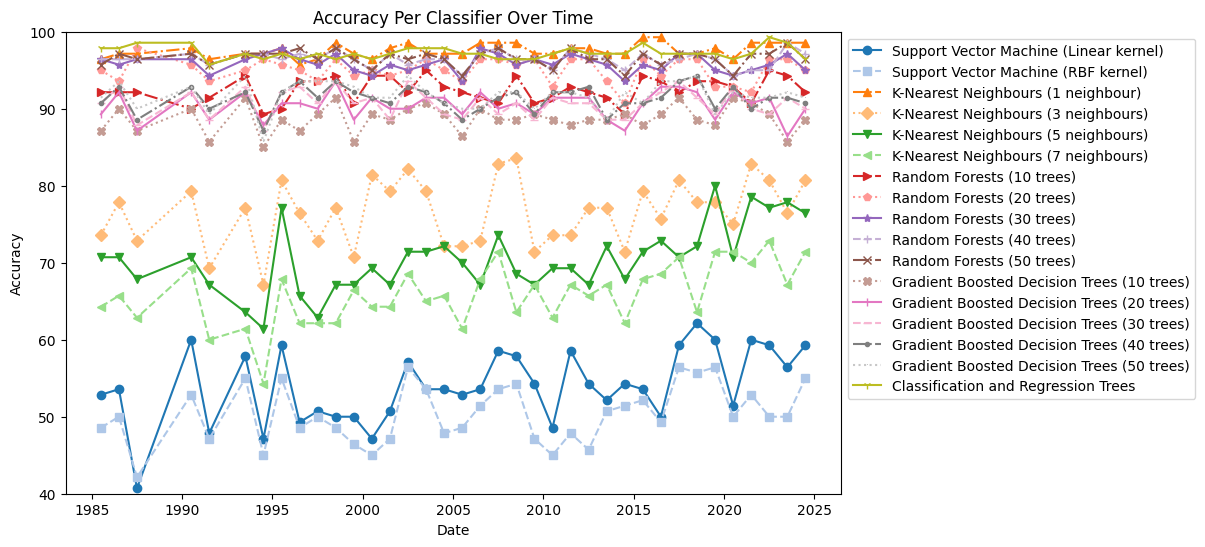

In [17]:
# plots for classification
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import datetime

errorPerClassifier = eval(open('./output/classError.txt', 'r').read())
dates = eval(open('./output/dates.txt', 'r').read())

# Mapping of classifier system names to descriptive names
name_mapping = {
    'ee.Classifier.libsvm(kernelType="LINEAR")': 'Support Vector Machine (Linear kernel)',
    'ee.Classifier.libsvm(kernelType="RBF")': 'Support Vector Machine (RBF kernel)',
    'ee.Classifier.smileKNN(k=1)': 'K-Nearest Neighbours (1 neighbour)',
    'ee.Classifier.smileKNN(k=3)': 'K-Nearest Neighbours (3 neighbours)',
    'ee.Classifier.smileKNN(k=5)': 'K-Nearest Neighbours (5 neighbours)',
    'ee.Classifier.smileKNN(k=7)': 'K-Nearest Neighbours (7 neighbours)',
    'ee.Classifier.smileRandomForest(10)': 'Random Forests (10 trees)',
    'ee.Classifier.smileRandomForest(20)': 'Random Forests (20 trees)',
    'ee.Classifier.smileRandomForest(30)': 'Random Forests (30 trees)',
    'ee.Classifier.smileRandomForest(40)': 'Random Forests (40 trees)',
    'ee.Classifier.smileRandomForest(50)': 'Random Forests (50 trees)',
    'ee.Classifier.smileGradientTreeBoost(10)': 'Gradient Boosted Decision Trees (10 trees)',
    'ee.Classifier.smileGradientTreeBoost(20)': 'Gradient Boosted Decision Trees (20 trees)',
    'ee.Classifier.smileGradientTreeBoost(30)': 'Gradient Boosted Decision Trees (30 trees)',
    'ee.Classifier.smileGradientTreeBoost(40)': 'Gradient Boosted Decision Trees (40 trees)',
    'ee.Classifier.smileGradientTreeBoost(50)': 'Gradient Boosted Decision Trees (50 trees)',
    'ee.Classifier.smileCart()': 'Classification and Regression Trees'
}

plt.figure(figsize=(10, 6))


# Color map and styles
color_map = plt.get_cmap('tab20').colors
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', '+', 'x', 'X', '|', '_', '.', ',', '1', '2']

# Plotting with mapped names
for idx, (classifier_code, errors) in enumerate(errorPerClassifier.items()):
    readable_name = name_mapping[classifier_code]  # Map the system name to a readable name
    ls = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    plt.plot(dates, [100*float(error) for error in errors], label=readable_name, color=color_map[idx], linestyle=ls, marker=marker)
    print(readable_name, np.array(errors).mean())

plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.title('Accuracy Per Classifier Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(40, 100)

plt.show()


In [8]:
# Computing Class images 
from datetime import datetime
from dateutil.relativedelta import relativedelta

training_points = ee.FeatureCollection([])
validation_points = ee.FeatureCollection([])
for value in classPoints.values():
    training_points = training_points.merge(value['training'])
    validation_points = validation_points.merge(value['validation'])


classifier = ee.Classifier.smileKNN(k=1)

startDate = datetime.strptime('1985-01-01', "%Y-%m-%d")
endDate = startDate + relativedelta(years=1)

areaObj = {name: [] for name in classNames}
images = []
confMatrixes = []

while endDate < datetime.strptime('2025-02-01', "%Y-%m-%d"):
    nonEmpty = True
    # Get cloud free image for the current month
    try:
        cloudFree, bands, res = getImageBandsRes(startDate, endDate, crudeBorders, True, True) 
        cloudFree.getInfo()
    except:
        nonEmpty = False
    if nonEmpty:
        # Overlay the points on the imagery to get bands for each point
        training = cloudFree.select(bands).sampleRegions(
            collection=training_points,
            properties=['landcover'],
            scale=res
        )
        validation = cloudFree.select(bands).sampleRegions(
            collection=validation_points,
            properties=['landcover'],
            scale=res
        )

        # Machine Learning: Classifier training and classification
        trainedClassifier = classifier.train(training, 'landcover', bands)
        classified = cloudFree.select(bands).classify(trainedClassifier)
        
        validated = validation.classify(trainedClassifier)
        confMatrix = validated.errorMatrix('landcover', 'classification')

        images.append(classified)
        confMatrixes.append(confMatrix)
        
        area_image = ee.Image.pixelArea().addBands(classified)
        areas = area_image.reduceRegion(
            reducer=ee.Reducer.sum().group(
                groupField=1,
                groupName="landcover",
            ),
            geometry=crudeBorders,
            scale=10,
        )
        
        area_list = areas.getInfo()["groups"]
        for area in area_list:
            className = reverse_classDict[area["landcover"]]
            areaObj[className].append(area["sum"])
        
    startDate = endDate 
    endDate += relativedelta(years=1)

print(areaObj)


{'Permanent_Water': [165430993.71171075, 167932862.563178, 116332329.06344849, 166215334.9319991, 167926270.80057952, 168608980.14456838, 142846048.6218456, 167670637.95048872, 168006554.18859765, 172244062.63025212, 169905846.3290398, 167900693.608402, 164882885.20897532, 166080774.89490288, 167285183.12083688, 166809272.87508672, 163065711.586931, 166757930.62695965, 165195078.99887973, 163202021.13588062, 168225033.87241346, 165213911.34727085, 161228496.61491466, 164519935.16581297, 157725476.69485587, 167690117.25485688, 165556290.22617307, 164426588.3803625, 167500357.76059628, 166908963.3496542, 164748711.6545095, 166923295.61660716, 167093582.10933465, 168652862.14104366, 168986019.68784237, 167403095.86862084, 167127433.75486287], 'Mangrove': [994576.6631317139, 847454.571647644, 12849173.060023021, 770422.2385940552, 871399.4808883667, 698668.1319885254, 5012864.773825343, 1252647.7043762207, 841057.9907836914, 628991.0993041992, 995731.5142669678, 528784.4602432251, 1086370.

37


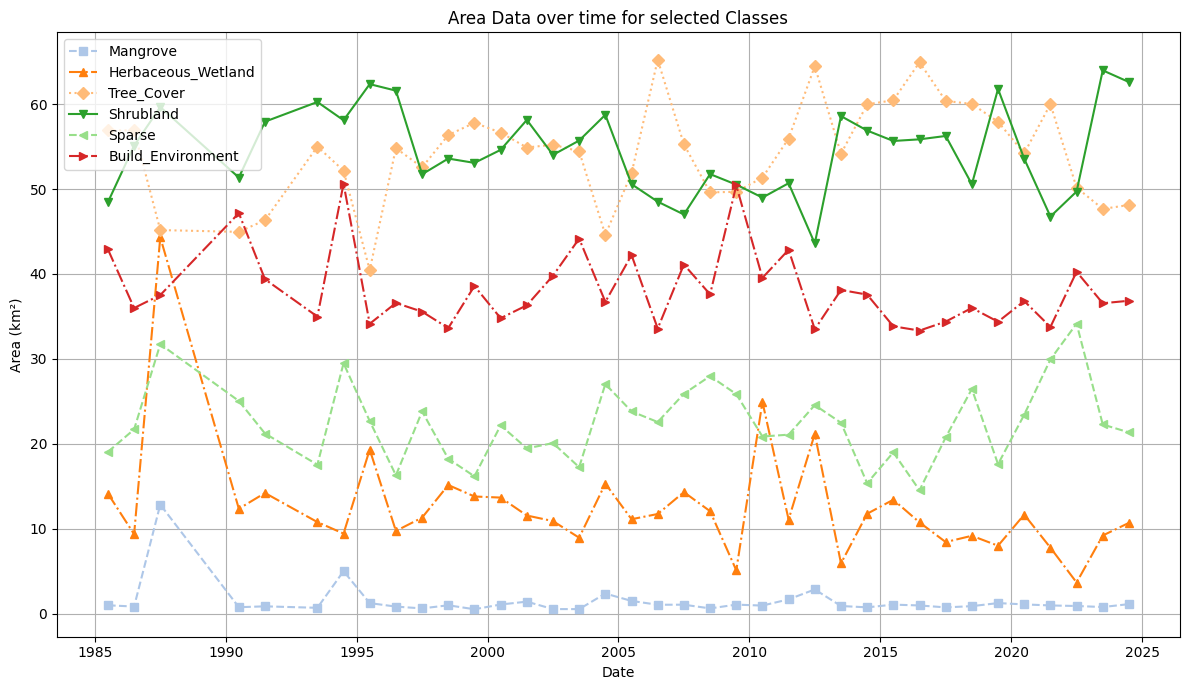

{'Permanent_Water': [165430993.71171075,
  167932862.563178,
  116332329.06344849,
  166215334.9319991,
  167926270.80057952,
  168608980.14456838,
  142846048.6218456,
  167670637.95048872,
  168006554.18859765,
  172244062.63025212,
  169905846.3290398,
  167900693.608402,
  164882885.20897532,
  166080774.89490288,
  167285183.12083688,
  166809272.87508672,
  163065711.586931,
  166757930.62695965,
  165195078.99887973,
  163202021.13588062,
  168225033.87241346,
  165213911.34727085,
  161228496.61491466,
  164519935.16581297,
  157725476.69485587,
  167690117.25485688,
  165556290.22617307,
  164426588.3803625,
  167500357.76059628,
  166908963.3496542,
  164748711.6545095,
  166923295.61660716,
  167093582.10933465,
  168652862.14104366,
  168986019.68784237,
  167403095.86862084,
  167127433.75486287],
 'Mangrove': [994576.6631317139,
  847454.571647644,
  12849173.060023021,
  770422.2385940552,
  871399.4808883667,
  698668.1319885254,
  5012864.773825343,
  1252647.704376220

In [24]:
# Compute the nice graph as in 'calculating areas.ipynb'
import matplotlib.pyplot as plt
import datetime
import numpy as np
areaObj = eval(open('./output/classAreas.txt', 'r').read())
dates = eval(open('./output/dates.txt', 'r').read())
print(len(areaObj['Permanent_Water']))
# Converting dates to month labels
month_labels = [date.strftime('%b') for date in dates]

# Plotting with adjusted x labels
plt.figure(figsize=(12, 7))

# Color map and styles
color_map = plt.get_cmap('tab20').colors
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', '+', 'x', 'X', '|', '_', '.', ',', '1', '2']


for idx, (className, values) in enumerate(areaObj.items()):
    if className == 'Permanent_Water':
        pass
    else:
        ls = line_styles[idx % len(line_styles)]
        marker = markers[idx % len(markers)]
        plt.plot(dates, np.array(values)/1000000, label=className, color=color_map[idx], linestyle=ls, marker=marker)

plt.xlabel('Date')
plt.ylabel('Area (km²)')
plt.title('Area Data over time for selected Classes')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

areaObj

In [37]:
# showing the classified maps
from datetime import datetime
m = geemap.Map()
# indices of desired dates and images.
indices = [0, 7, 17, 27, 36]
image, _, _ = getImageBandsRes(datetime.strptime(f'2023-01-01', "%Y-%m-%d"), datetime.strptime(f'2023-12-31', "%Y-%m-%d"), crudeBorders, False, True)
m.addLayer(image, regVis, 'RGB image')
for i in indices:
    m.addLayer(images[i], classVis, f'classification at date: {dates[i]}')
m.centerObject(images[0])
m.to_html(filename='./classified_images.html')

mean Accuracy for Permanent_Water: 1.0
mean Accuracy for Mangrove: 1.0
mean Accuracy for Herbaceous_Wetland: 0.981081081081081
mean Accuracy for Tree_Cover: 1.0
mean Accuracy for Shrubland: 1.0
mean Accuracy for Sparse: 0.8837837837837836
mean Accuracy for Build_Environment: 0.9662162162162162


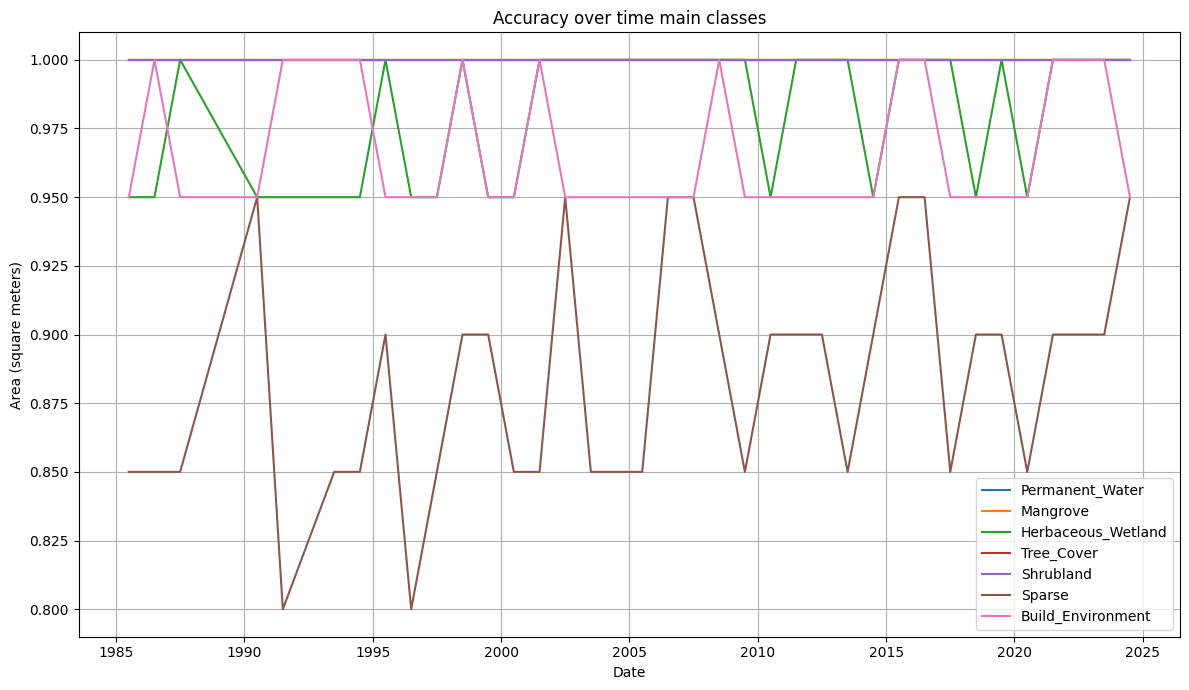

In [25]:
# calculate errors optimal classifier per class over time
import matplotlib.pyplot as plt
import numpy as np

classAcc = [[] for className in classNames]
for confMatrix in confMatrixes:
    for i, row in enumerate(confMatrix.getInfo()):
        rowAcc = row[i]/20
        classAcc[i].append(rowAcc)

plt.figure(figsize=(12, 7))
for i, className in enumerate(classNames):
    print(f'mean Accuracy for {className}: {np.mean(np.array(classAcc[i]))}')
    plt.plot(dates, classAcc[i], label=className)

plt.xlabel('Date')
plt.ylabel('Area (square meters)')
plt.title('Accuracy over time main classes')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [11]:
# deleting images in bulk

def conditional_asset_rm(x, starts_with):
    """Deletes asset if starts with starts_with """
    id = x["id"]              # users/username/file  or projects/project-name/assets/file
    findex = 5 if id.startswith("users") else 3
    name = x["name"]          # projects/earthengine-legacy/assets/users/username/file or projects/project-name/assets/file
    f = name.split("/")[findex]  # file
    if (f.startswith(starts_with)):
        ee.data.deleteAsset(id)
        return f"Deleted asset {id}"
    
    return 0

# Define the folder path
folder_path = 'projects/aruba-tdf/assets/subClassImages/'

# List all assets in the folder
assets = ee.data.listAssets({'parent': folder_path})['assets']

[conditional_asset_rm(x, "") for x in assets]

['Deleted asset projects/aruba-tdf/assets/subClassImages/1985-07_Build_Environment',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/1985-07_Herbaceous_Wetland',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/1985-07_Sparse',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/1985-07_Tree_Cover',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/1986-07_Build_Environment',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/1986-07_Herbaceous_Wetland',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/1986-07_Sparse',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/1986-07_Tree_Cover',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/1987-07_Build_Environment',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/1987-07_Herbaceous_Wetland',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/1987-07_Sparse',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/1987-07_Tree_Cover',
 'Deleted asset projects/aruba-

In [11]:
# Exporting Resulting images to Google Earth Engine:
import datetime
dates = eval(open('./output/dates.txt', 'r').read())
for i, image in enumerate(images):
    selectedDate = dates[i].strftime('%Y-%m')
    task = ee.batch.Export.image.toAsset(
        image=image,
        description='image_export',
        assetId=f'projects/aruba-tdf/assets/images/{selectedDate}',  
        scale=30,
        crs='EPSG:4326'
    )
    task.start()

In [3]:
# Calculating Error subclasses 
accuracy = {className: {name: [] for name in mlNames} for (className, value) in classesFromSubClasses.items() if len(value) > 1}

startDate = datetime.strptime('1985-01-01', "%Y-%m-%d")
endDate = startDate + relativedelta(years=1)
dates = []

while endDate < datetime.strptime('2025-02-01', "%Y-%m-%d"):
  nonEmpty = True
  # Get cloud free image for the current month
  try:
    cloudFree, bands, res = getImageBandsRes(startDate, endDate, crudeBorders, True, True) 
    cloudFree.getInfo()
  except:
    nonEmpty = False
  if nonEmpty:
    midDate = startDate + (endDate - startDate)/2
    dates.append(midDate)
    classImage = ee.Image(f'projects/aruba-tdf/assets/classImages/{midDate.strftime("%Y-%m")}')
      
    for className in classNames:
      subClassesForClass = []
      for index in classesFromSubClasses[className]:
        subClassesForClass.append(subClassNames[index])

      if len(subClassesForClass) == 1:
        # no subclasses
        pass
      elif len(subClassesForClass) > 1:
        mask = classImage.select('classification').eq(classNames.index(className))
        maskedImage = cloudFree.updateMask(mask)
        # points for all subclasses, with distinguishing 'landcover' parameter
        training_points = ee.FeatureCollection([])
        validation_points = ee.FeatureCollection([])
        for i, name in enumerate(subClassesForClass):
          training_points = training_points.merge(ee.FeatureCollection(subClassPoints[name]['training']).map(lambda feature: feature.set({'landcover': i})))
          validation_points = validation_points.merge(ee.FeatureCollection(subClassPoints[name]['validation']).map(lambda feature: feature.set({'landcover': i})))

        training = cloudFree.select(bands).sampleRegions(
          collection=training_points,
          properties=['landcover'],
          scale=res
          )
        
        validation = cloudFree.select(bands).sampleRegions(
          collection=validation_points,
          properties=['landcover'],
          scale=res
          )
        
        for method in mlNames:
          # lastly, for every method do this
          classifier = eval(method)

          trainedClassifier = classifier.train(training, 'landcover', bands)
          classified = maskedImage.select(bands).classify(trainedClassifier)

          validated = validation.classify(trainedClassifier)
          confusionMatrix = validated.errorMatrix('landcover', 'classification')
          acc = confusionMatrix.accuracy().getInfo()
          accuracy[className][method].append(acc)
          print(endDate, className, method, acc)
          
  
  startDate = endDate 
  endDate += relativedelta(years=1)


print(accuracy)


1986-01-01 00:00:00 Herbaceous_Wetland ee.Classifier.libsvm(kernelType="LINEAR") 0.6666666666666666
1986-01-01 00:00:00 Herbaceous_Wetland ee.Classifier.libsvm(kernelType="RBF") 0.6666666666666666
1986-01-01 00:00:00 Herbaceous_Wetland ee.Classifier.smileKNN(k=1) 0.8
1986-01-01 00:00:00 Herbaceous_Wetland ee.Classifier.smileKNN(k=3) 0.7666666666666667
1986-01-01 00:00:00 Herbaceous_Wetland ee.Classifier.smileKNN(k=5) 0.8333333333333334
1986-01-01 00:00:00 Herbaceous_Wetland ee.Classifier.smileKNN(k=7) 0.8166666666666667
1986-01-01 00:00:00 Herbaceous_Wetland ee.Classifier.smileRandomForest(10) 0.8333333333333334
1986-01-01 00:00:00 Herbaceous_Wetland ee.Classifier.smileRandomForest(20) 0.8166666666666667
1986-01-01 00:00:00 Herbaceous_Wetland ee.Classifier.smileRandomForest(30) 0.8333333333333334
1986-01-01 00:00:00 Herbaceous_Wetland ee.Classifier.smileRandomForest(40) 0.85
1986-01-01 00:00:00 Herbaceous_Wetland ee.Classifier.smileRandomForest(50) 0.8333333333333334
1986-01-01 00:00:0

Support Vector Machine (Linear kernel) 0.5671171171171171
Support Vector Machine (RBF kernel) 0.5590090090090091
K-Nearest Neighbours (1 neighbour) 0.7000000000000001
K-Nearest Neighbours (3 neighbours) 0.6756756756756758
K-Nearest Neighbours (5 neighbours) 0.6585585585585586
K-Nearest Neighbours (7 neighbours) 0.649099099099099
Random Forests (10 trees) 0.6990990990990992
Random Forests (20 trees) 0.7072072072072072
Random Forests (30 trees) 0.7225225225225226
Random Forests (40 trees) 0.7202702702702702
Random Forests (50 trees) 0.7207207207207207
Gradient Boosted Decision Trees (10 trees) 0.7076576576576575
Gradient Boosted Decision Trees (20 trees) 0.7067567567567566
Gradient Boosted Decision Trees (30 trees) 0.713963963963964
Gradient Boosted Decision Trees (40 trees) 0.7112612612612612
Gradient Boosted Decision Trees (50 trees) 0.7099099099099098
Classification and Regression Trees 0.6783783783783784


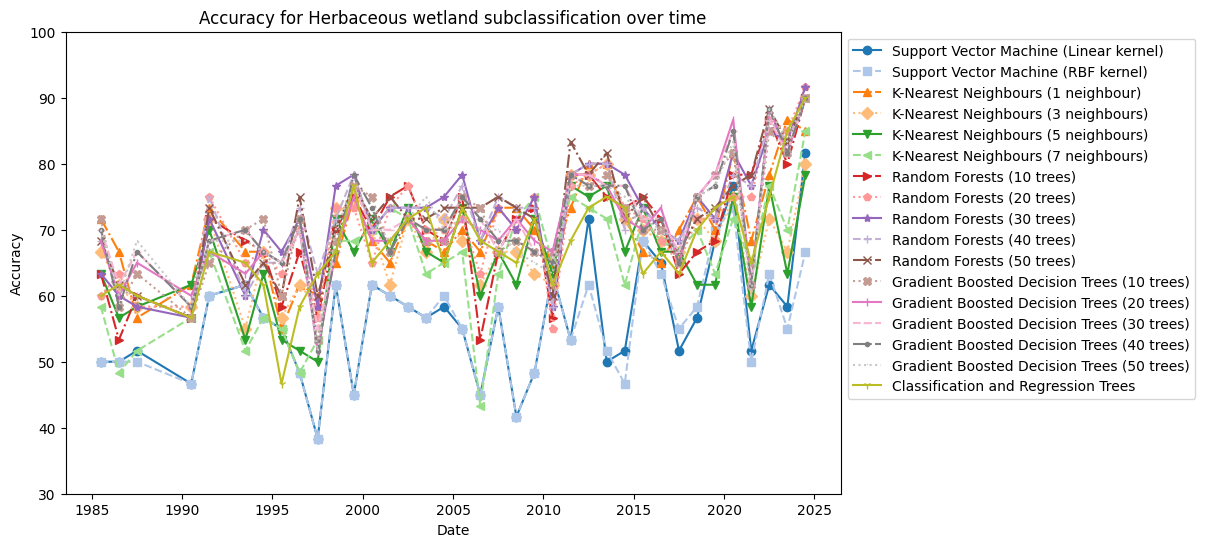

In [7]:
# Error analysis subclasses
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np

# Mapping of classifier system names to descriptive names
name_mapping = {
    'ee.Classifier.libsvm(kernelType="LINEAR")': 'Support Vector Machine (Linear kernel)',
    'ee.Classifier.libsvm(kernelType="RBF")': 'Support Vector Machine (RBF kernel)',
    'ee.Classifier.smileKNN(k=1)': 'K-Nearest Neighbours (1 neighbour)',
    'ee.Classifier.smileKNN(k=3)': 'K-Nearest Neighbours (3 neighbours)',
    'ee.Classifier.smileKNN(k=5)': 'K-Nearest Neighbours (5 neighbours)',
    'ee.Classifier.smileKNN(k=7)': 'K-Nearest Neighbours (7 neighbours)',
    'ee.Classifier.smileRandomForest(10)': 'Random Forests (10 trees)',
    'ee.Classifier.smileRandomForest(20)': 'Random Forests (20 trees)',
    'ee.Classifier.smileRandomForest(30)': 'Random Forests (30 trees)',
    'ee.Classifier.smileRandomForest(40)': 'Random Forests (40 trees)',
    'ee.Classifier.smileRandomForest(50)': 'Random Forests (50 trees)',
    'ee.Classifier.smileGradientTreeBoost(10)': 'Gradient Boosted Decision Trees (10 trees)',
    'ee.Classifier.smileGradientTreeBoost(20)': 'Gradient Boosted Decision Trees (20 trees)',
    'ee.Classifier.smileGradientTreeBoost(30)': 'Gradient Boosted Decision Trees (30 trees)',
    'ee.Classifier.smileGradientTreeBoost(40)': 'Gradient Boosted Decision Trees (40 trees)',
    'ee.Classifier.smileGradientTreeBoost(50)': 'Gradient Boosted Decision Trees (50 trees)',
    'ee.Classifier.smileCart()': 'Classification and Regression Trees'
}

plt.figure(figsize=(10, 6))

# Color map and styles
color_map = plt.get_cmap('tab20').colors
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', '+', 'x', 'X', '|', '_', '.', ',', '1', '2']

# structure: {class1: {method1: [], method2: []}, class2: ...}
accuracy = eval(open('./output/subClassError.txt', 'r').read())
dates = eval(open('./output/dates.txt', 'r').read())
# Choose manually from: Herbaceous_Wetland, Tree_Cover, Sparse, Build_Environment
className = 'Build_Environment'
subAccuracy = accuracy[className]

# Plotting with mapped names
for idx, (classifier_code, errors) in enumerate(subAccuracy.items()):
    readable_name = name_mapping[classifier_code]  # Map the system name to a readable name
    ls = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    plt.plot(dates, [100*float(error) for error in errors], label=readable_name, color=color_map[idx], linestyle=ls, marker=marker)
    print(readable_name, np.array(errors).mean())

plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.title(f'Accuracy for Herbaceous wetland subclassification over time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(30, 100)

plt.show()


In [10]:
# Subclassification results for best performing classifiers
import ee 
from datetime import datetime

# Change to best performing classifiers! grad boost 10 trees, knn1, rf30
subclassClassifiers = {'Herbaceous_Wetland': 'ee.Classifier.smileKNN(k=1)', 'Tree_Cover': 'ee.Classifier.smileGradientTreeBoost(10)', 'Sparse': 'ee.Classifier.smileKNN(k=1)', 'Build_Environment': 'ee.Classifier.smileRandomForest(40)'}

startDate = datetime.strptime('1985-01-01', "%Y-%m-%d")
endDate = startDate + relativedelta(years=1)

images = {className: [] for className in subclassClassifiers.keys()}
confMatrixes = {className: [] for className in subclassClassifiers.keys()}

areaObj = {name: [] for name in subClassNames}
landcoverOffset = {'Herbaceous_Wetland': 2, 'Tree_Cover': 5, 'Sparse': 9, 'Build_Environment': 15}

while endDate < datetime.strptime('2025-02-01', "%Y-%m-%d"):
  nonEmpty = True
  # Get cloud free image for the current month
  try:
    cloudFree, bands, res = getImageBandsRes(startDate, endDate, crudeBorders, True, True) 
    cloudFree.getInfo()
  except:
    nonEmpty = False
  if nonEmpty:
    midDate = startDate + (endDate - startDate)/2
    classImage = ee.Image(f'projects/aruba-tdf/assets/classImages/{midDate.strftime("%Y-%m")}')
    for className, method in subclassClassifiers.items():
      # For every class do the following
      mask = classImage.select('classification').eq(classNames.index(className))
      maskedImage = cloudFree.updateMask(mask)
      
      subClassesForClass = []
      for index in classesFromSubClasses[className]:
        subClassesForClass.append(subClassNames[index])

      training_points = ee.FeatureCollection([])
      validation_points = ee.FeatureCollection([])
      for i, name in enumerate(subClassesForClass):
        training_points = training_points.merge(ee.FeatureCollection(subClassPoints[name]['training']).map(lambda feature: feature.set({'landcover': i})))
        validation_points = validation_points.merge(ee.FeatureCollection(subClassPoints[name]['validation']).map(lambda feature: feature.set({'landcover': i})))

      training = cloudFree.select(bands).sampleRegions(
        collection=training_points,
        properties=['landcover'],
        scale=res
      )
        
      validation = cloudFree.select(bands).sampleRegions(
        collection=validation_points,
        properties=['landcover'],
        scale=res
      )
        
      classifier = eval(method)
      trainedClassifier = classifier.train(training, 'landcover', bands)
      classified = maskedImage.select(bands).classify(trainedClassifier)
      images[className].append(classified)

      validated = validation.classify(trainedClassifier)
      confMatrix = validated.errorMatrix('landcover', 'classification')
      confMatrixes[className].append(confMatrix)

      area_image = ee.Image.pixelArea().addBands(classified)
      areas = area_image.reduceRegion(
        reducer=ee.Reducer.sum().group(
            groupField=1,
            groupName="landcover",
        ),
        geometry=crudeBorders,
        scale=res,
      )

      area_list = areas.getInfo()["groups"]
      for i, area in enumerate(area_list):
        landcover = landcoverOffset[className] + i
        areaObj[reverse_subClassDict[landcover]].append(area["sum"])
      
      print(className, startDate)
  
    
  startDate = endDate 
  endDate += relativedelta(years=1)

print(areaObj)

Herbaceous_Wetland 1985-01-01 00:00:00
Tree_Cover 1985-01-01 00:00:00
Sparse 1985-01-01 00:00:00
Build_Environment 1985-01-01 00:00:00
Herbaceous_Wetland 1986-01-01 00:00:00
Tree_Cover 1986-01-01 00:00:00
Sparse 1986-01-01 00:00:00
Build_Environment 1986-01-01 00:00:00
Herbaceous_Wetland 1987-01-01 00:00:00
Tree_Cover 1987-01-01 00:00:00
Sparse 1987-01-01 00:00:00
Build_Environment 1987-01-01 00:00:00
Herbaceous_Wetland 1990-01-01 00:00:00
Tree_Cover 1990-01-01 00:00:00
Sparse 1990-01-01 00:00:00
Build_Environment 1990-01-01 00:00:00
Herbaceous_Wetland 1991-01-01 00:00:00
Tree_Cover 1991-01-01 00:00:00
Sparse 1991-01-01 00:00:00
Build_Environment 1991-01-01 00:00:00
Herbaceous_Wetland 1993-01-01 00:00:00
Tree_Cover 1993-01-01 00:00:00
Sparse 1993-01-01 00:00:00
Build_Environment 1993-01-01 00:00:00
Herbaceous_Wetland 1994-01-01 00:00:00
Tree_Cover 1994-01-01 00:00:00
Sparse 1994-01-01 00:00:00
Build_Environment 1994-01-01 00:00:00
Herbaceous_Wetland 1995-01-01 00:00:00
Tree_Cover 1995-

In [12]:
# exporting subclass images to Gee
for className, imagesList in images.items():
    for i, image in enumerate(imagesList):
        selectedDate = dates[i].strftime('%Y-%m')
        task = ee.batch.Export.image.toAsset(
            image=image,
            description='image_export',
            assetId=f'projects/aruba-tdf/assets/subClassImages/{selectedDate}_{className}',  
            scale=30,
            crs='EPSG:4326'
        )
        task.start()


In [23]:
# deleting images in bulk
def conditional_asset_rm(x, starts_with):
    """Deletes asset if starts with starts_with """
    id = x["id"]              # users/username/file  or projects/project-name/assets/file
    findex = 5 if id.startswith("users") else 3
    name = x["name"]          # projects/earthengine-legacy/assets/users/username/file or projects/project-name/assets/file
    f = name.split("/")[findex]  # file
    if (f.startswith(starts_with)):
        ee.data.deleteAsset(id)
        return f"Deleted asset {id}"
    
    return 0

# Define the folder path
folder_path = 'projects/aruba-tdf/assets/subClassImages/'

# List all assets in the folder
assets = ee.data.listAssets({'parent': folder_path})['assets']

[conditional_asset_rm(x, "") for x in assets]

['Deleted asset projects/aruba-tdf/assets/subClassImages/Herbaceous_Wetland_2001-07',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/Herbaceous_Wetland_2002-07',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/Herbaceous_Wetland_2003-07',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/Herbaceous_Wetland_2004-07',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/Herbaceous_Wetland_2005-07',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/Herbaceous_Wetland_2006-07',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/Herbaceous_Wetland_2007-07',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/Herbaceous_Wetland_2008-07',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/Herbaceous_Wetland_2009-07',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/Herbaceous_Wetland_2010-07',
 'Deleted asset projects/aruba-tdf/assets/subClassImages/Herbaceous_Wetland_2011-07',
 'Deleted asset projects/aruba-tdf/assets/subClassImag

37 37


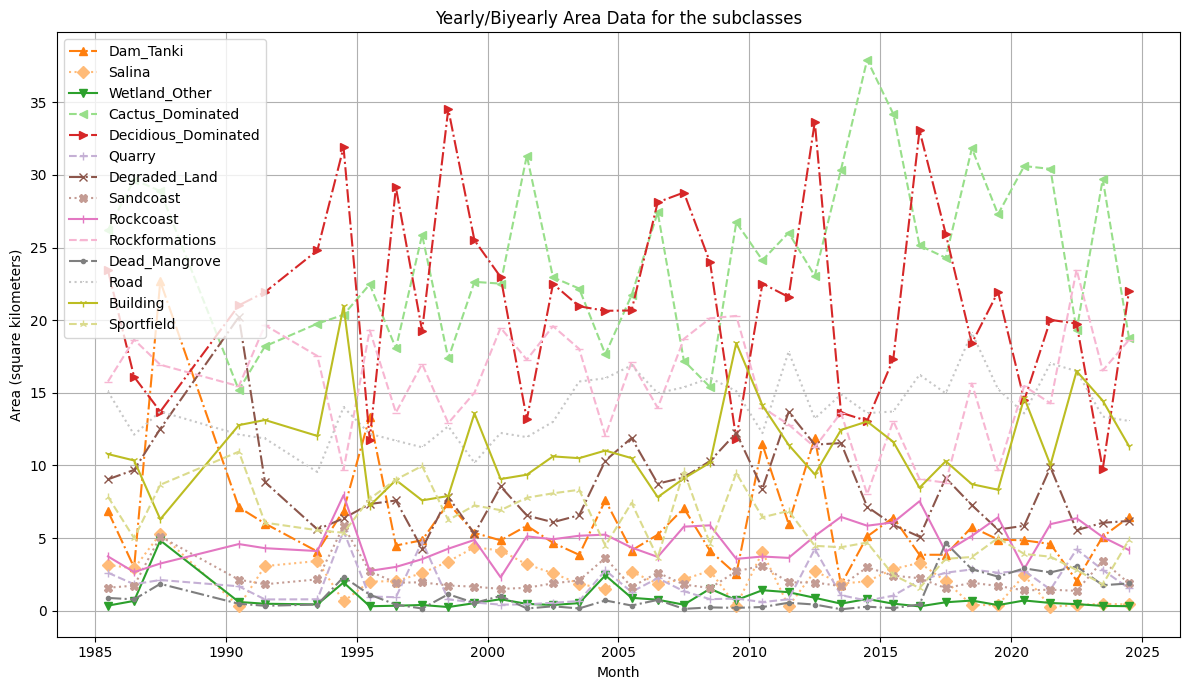

In [8]:
import datetime
import matplotlib.pyplot as plt

# Read the data
subClassAreas = eval(open('output/subClassAreas.txt', 'r').read())
dates = eval(open('output/dates.txt', 'r').read())

print(len(subClassAreas['Building']), len(dates))
# Convert areas from square meters to square kilometers
for subClass, areas in subClassAreas.items():
    subClassAreas[subClass] = [area / 1_000_000 for area in areas]

# Color map and styles
color_map = plt.get_cmap('tab20').colors
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', '+', 'x', 'X', '|', '_', '.', ',', '1', '2']

# Plotting with adjusted x labels
plt.figure(figsize=(12, 7))
for idx, (subClass, areas) in enumerate(subClassAreas.items()):
    if len(areas) > 0: 
        ls = line_styles[idx % len(line_styles)]
        marker = markers[idx % len(markers)]
        plt.plot(dates, areas, label=subClass, color=color_map[idx], linestyle=ls, marker=marker)

plt.xlabel('Month')
plt.ylabel('Area (square kilometers)')
plt.title('Yearly/Biyearly Area Data for the subclasses')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [10]:
# display the maps for a time
# Classified map of 1985, 1992, 2000, 2007, 2015 (1e), 2018 (2e), 2021 (2e), 2024 (1e).
from datetime import datetime
m = geemap.Map()

indices = [0, 5, 13, 20, 28, 33, 41, 44]
herbVis = {
  'min': 0,
  'max': 2,
  'palette': [
    '00BFFF',  # Dam/Tanki: Deep Sky Blue
    'ADD8E6',  # Salina: Light Blue
    '228B22',  # Wetland_Other: Forest Green
  ]
}

treeVis = {
  'min': 0,
  'max': 1,
  'palette': [
    '556B2F',  # Cactus_Dominated: Dark Olive Green
    '3CB371',  # Deciduous_Dominated: Medium Sea Green
  ]
}

sparseVis = {
  'min': 0,
  'max': 5,
  'palette': [
    'FF8C00',  # Quarry: Dark Orange
    'DC143C',  # Degraded_Land: Crimson
    'F4A460',  # Sandcoast: Sandy Brown
    '708090',  # Rockcoast: Slate Gray
    'A0522D',  # Rockformations: Sienna
    '9932CC',  # Dead Mangrove: Dark Orchid
  ]
}

buildVis = {
  'min': 0,
  'max': 2,
  'palette': [
    '000000',
    'FF0000',
    '1E90FF'
  ]
}


backgroundImage, _, _ = getImageBandsRes(datetime.strptime(f'2023-01-01', "%Y-%m-%d"), datetime.strptime(f'2023-12-31', "%Y-%m-%d"), crudeBorders, False, True)
m.addLayer(backgroundImage, regVis, 'background image')
m.centerObject(backgroundImage)

for i in indices:
    date = dates[i].strftime('%Y-%m')
    classImage = ee.Image(f'projects/aruba-tdf/assets/classImages/{date}')
    m.addLayer(classImage, classVis, f'class {date}')
    m.addLayer(images['Herbaceous_Wetland'][0], herbVis, f'herb {date}')
    m.addLayer(images['Tree_Cover'][0], treeVis, f'tree {date}')
    m.addLayer(images['Sparse'][0], sparseVis, f'sparse {date}')
    m.addLayer(images['Build_Environment'][0], buildVis, f'build {date}')

m.to_html(filename='subclassified_images.html')

NameError: name 'images' is not defined

In [12]:
# calculate errors optimal classifier per subclass over time
import matplotlib.pyplot as plt
import numpy as np

subClassNames = ['Dam_Tanki', 'Salina', 'Wetland_Other', 'Cactus_Dominated', 'Decidious_Dominated',  
               'Quarry', 'Degraded_Land', 'Sandcoast', 'Rockcoast', 'Rockformations', 'Dead_Mangrove', 'Road', 'Building', 'Sportfield']


subClassAcc = {name: [[] for i in classesFromSubClasses[name]] for name in landcoverOffset.keys()}
print(subClassAcc)
for j, (className, confMatrixList) in enumerate(confMatrixes.items()):
    for k, confMatrix in enumerate(confMatrixList):    
        for i, row in enumerate(confMatrix.getInfo()):
            rowAcc = row[i]/20
            subClassAcc[className][i].append(rowAcc)
        print(dates[k])

for i, subClassName in enumerate(subClassNames):
    print(f'mean Accuracy for {subClassName}: {np.mean(np.array(subClassAcc[i]))}')

{'Herbaceous_Wetland': [[], [], []], 'Tree_Cover': [[], []], 'Sparse': [[], [], [], [], [], []], 'Build_Environment': [[], [], []]}


NameError: name 'confMatrixes' is not defined

In [80]:
accLists = []
for name in landcoverOffset.keys():
    print(name)
    for arr in subClassAcc[name]:
        accLists.append(arr)

for i, subClassName in enumerate(subClassNames):
    print(f'mean Accuracy for {subClassName}: {np.mean(np.array(accLists[i]))}')

Herbaceous_Wetland
Tree_Cover
Sparse
Build_Environment
mean Accuracy for Dam_Tanki: 0.8955555555555557
mean Accuracy for Salina: 0.9811111111111113
mean Accuracy for Wetland_Other: 0.9711111111111111
mean Accuracy for Cactus_Dominated: 0.8233333333333335
mean Accuracy for Decidious_Dominated: 0.4277777777777777
mean Accuracy for Quarry: 0.8444444444444444
mean Accuracy for Degraded_Land: 0.8511111111111114
mean Accuracy for Sandcoast: 0.8788888888888888
mean Accuracy for Rockcoast: 0.7566666666666667
mean Accuracy for Rockformations: 0.8200000000000002
mean Accuracy for Dead_Mangrove: 0.8888888888888891
mean Accuracy for Road: 0.7922222222222224
mean Accuracy for Building: 0.5800000000000001
mean Accuracy for Sportfield: 0.93


In [14]:
m = geemap.Map()
treeVis = {
  'min': 0,
  'max': 1,
  'palette': [
    '000000',  # Cactus_Dominated: Dark Olive Green
    '10e250',  # Deciduous_Dominated: Medium Sea Green
  ]
}

image = ee.Image(f'projects/aruba-tdf/assets/subClassImages/1985-07_Tree_Cover')
maskedImage1 = image.updateMask(image.select('classification').neq(0))
maskedImage2 = image.updateMask(image.select('classification').neq(1))
m.addLayer(maskedImage1, treeVis)
m.addLayer(maskedImage2, treeVis)
m.centerObject(image)
m
    

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [2]:
# # calculate SDG 15.1.1
import datetime

# Function to calculate the area of a feature and return it only if 'landcover' equals 1 and area is greater than 200m2
def calculate_area(feature):
    landcover = feature.get('landcover')
    # Check if landcover is 1. WHY?
    if ee.Number(landcover).eq(1):
        # Calculate area in square meters
        area = feature.geometry().area(10)  # Ensure area is in square meters
        # Check if the area is greater than 5000m2 as desired from sdg def
        if area.gt(5000):
            return ee.Feature(None, {'area': area})
    # Return a feature with area 0 if conditions are not met
    return ee.Feature(None, {'area': 0})


dates = eval(open('./output/dates.txt', 'r').read())
treeCoverAreas = {'Mangrove': [], 'Decideous': [], 'Cactus': [], 'Forest': [], 'Tropical Dry Forest': []}

for date in dates:
    formattedDate = date.strftime('%Y-%m')
    res = 30 
    classImage = ee.Image(f'projects/aruba-tdf/assets/classImages/{formattedDate}')
    subClassImage = ee.Image(f'projects/aruba-tdf/assets/subClassImages/{formattedDate}_Tree_Cover')
    
    # First calculate areas of Mangrove
    maskedImage = classImage.updateMask(classImage.select('classification').eq(1))
    vector_image = maskedImage.addBands(classImage).reduceToVectors(
        geometry=crudeBorders,
        crs=classImage.projection(),
        scale=res,
        geometryType='polygon',
        eightConnected=False,
        labelProperty='landcover',
        reducer=ee.Reducer.mean()
    )
    areas = vector_image.map(calculate_area)
    total_area = areas.aggregate_sum('area')
    treeCoverAreas['Mangrove'].append(total_area.getInfo())

    # Then also for Cactus and Decideous
    for i, subClass in enumerate(['Cactus','Decideous']):
        maskedImage = subClassImage.updateMask(subClassImage.select('classification').eq(i))
        vector_image = maskedImage.addBands(subClassImage).reduceToVectors(
            geometry=crudeBorders,
            crs=subClassImage.projection(),
            scale=res,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )
        areas = vector_image.map(calculate_area)
        total_area = areas.aggregate_sum('area')
        treeCoverAreas[subClass].append(total_area.getInfo())
    
    treeCoverAreas['Forest'].append(treeCoverAreas['Decideous'][-1] + treeCoverAreas['Mangrove'][-1])
    treeCoverAreas['Tropical Dry Forest'].append(treeCoverAreas['Decideous'][-1] + treeCoverAreas['Cactus'][-1] + treeCoverAreas['Mangrove'][-1])

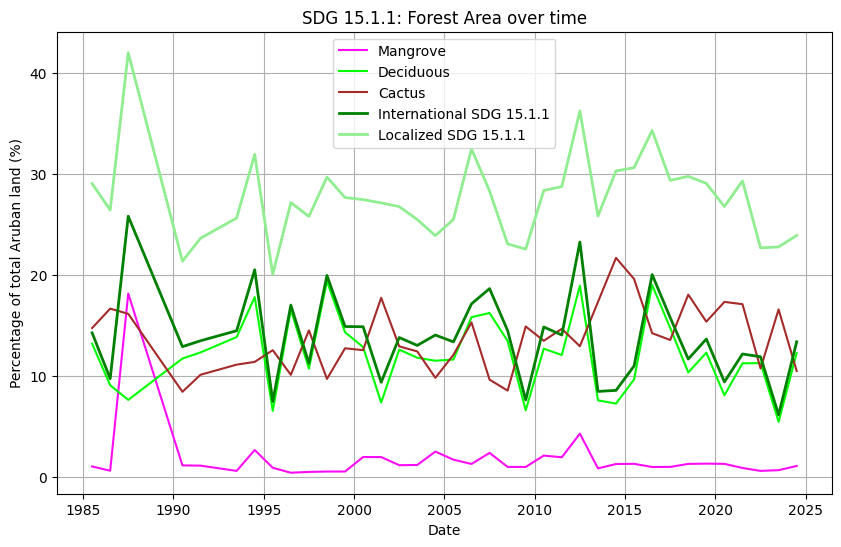

In [4]:
# plot SDG 15.1.1
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
arubanSize = 180.56

# Plot each tree cover area
plt.plot(dates, np.array(treeCoverAreas['Mangrove'])/1000000/arubanSize*100, label='Mangrove', color=classPalette[1])
plt.plot(dates, np.array(treeCoverAreas['Decideous'])/1000000/arubanSize*100, label='Deciduous', color=classPalette[2])
plt.plot(dates, np.array(treeCoverAreas['Cactus'])/1000000/arubanSize*100, label='Cactus', color='brown')
plt.plot(dates, np.array(treeCoverAreas['Forest'])/1000000/arubanSize*100, label='International SDG 15.1.1', color='green', linewidth=2)
plt.plot(dates, np.array(treeCoverAreas['Tropical Dry Forest'])/1000000/arubanSize*100, label='Localized SDG 15.1.1', color='lightgreen', linewidth=2)

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Percentage of total Aruban land (%)')
plt.title('SDG 15.1.1: Forest Area over time')
plt.legend()
plt.grid(True)
plt.show()

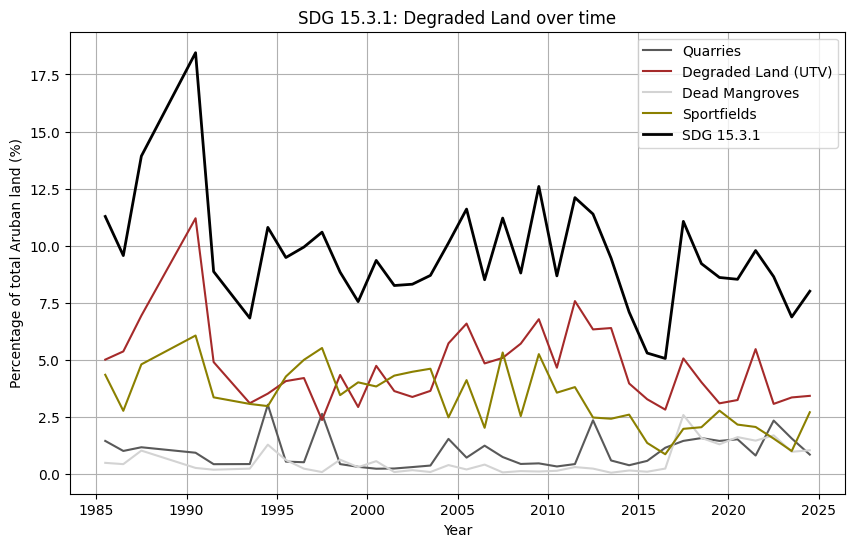

In [11]:
# Calculate SDG 15.3.1: Degraded Land 
# Subclasses: Quarry, Degraded_Land, Dead_Mangrove, Sportfields
arubanSize = 180.56

import numpy as np
quarriesAverages = np.array(subClassAreas['Quarry'])/1000000/arubanSize*100
degradAverages = np.array(subClassAreas['Degraded_Land'])/1000000/arubanSize*100
deadMangroveAverages = np.array(subClassAreas['Dead_Mangrove'])/1000000/arubanSize*100
sportfield = np.array(subClassAreas['Sportfield'])/1000000/arubanSize*100

degradedLand = quarriesAverages + degradAverages + deadMangroveAverages + sportfield

plt.figure(figsize=(10, 6))
plt.plot(dates, quarriesAverages, label='Quarries', color='#595959')
plt.plot(dates, degradAverages, label='Degraded Land (UTV)', color='brown')
plt.plot(dates, deadMangroveAverages, label='Dead Mangroves', color='#D3D3D3')
plt.plot(dates, sportfield, label='Sportfields', color='#8B8000')
plt.plot(dates, degradedLand, label='SDG 15.3.1', linewidth=2, color='black')

plt.title('SDG 15.3.1: Degraded Land over time')
plt.xlabel('Year')
plt.ylabel('Percentage of total Aruban land (%)')
plt.legend()
plt.grid(True)
plt.show()



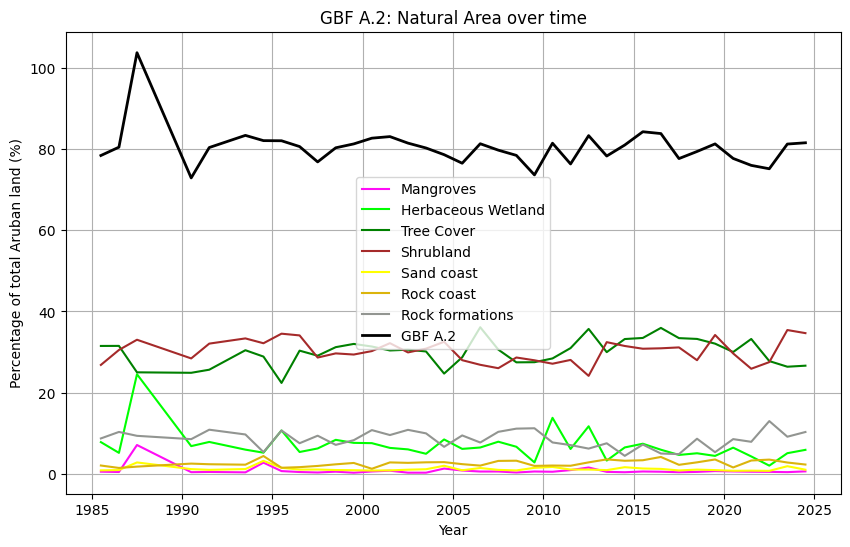

In [9]:
# Calculate GBF A.2
# Classes: Mangroves, Herbacious Wetland, Tree Cover, Shrubland
# Subclasses: Sandcoast, Rockycoast, Rockformations
import numpy as np
import matplotlib.pyplot as plt
import datetime
arubanSize = 180.56

# Assuming classAreas and subClassAreas are dictionaries containing the area data
classAreas = eval(open('./output/classAreas.txt', 'r').read())
subClassAreas = eval(open('./output/subClassAreas.txt', 'r').read())
dates = eval(open('./output/dates.txt', 'r').read())

# Calculate the averages for the classes and subclasses
mangroveAverages = np.array(classAreas['Mangrove']) / 1000000/arubanSize*100
herbaciousWetlandAverages = np.array(classAreas['Herbaceous_Wetland']) / 1000000/arubanSize*100
treeCoverAverages = np.array(classAreas['Tree_Cover']) / 1000000/arubanSize*100
shrublandAverages = np.array(classAreas['Shrubland']) / 1000000/arubanSize*100

sandcoastAverages = np.array(subClassAreas['Sandcoast']) / 1000000/arubanSize*100
rockycoastAverages = np.array(subClassAreas['Rockcoast']) / 1000000/arubanSize*100
rockformationsAverages = np.array(subClassAreas['Rockformations']) / 1000000/arubanSize*100

# Calculate the cumulative averages
naturalArea = (mangroveAverages + herbaciousWetlandAverages + treeCoverAverages + 
               shrublandAverages + sandcoastAverages + rockycoastAverages + rockformationsAverages)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, mangroveAverages, label='Mangroves', color=classPalette[1])
plt.plot(dates, herbaciousWetlandAverages, label='Herbaceous Wetland', color=classPalette[2])
plt.plot(dates, treeCoverAverages, label='Tree Cover', color=classPalette[3])
plt.plot(dates, shrublandAverages, label='Shrubland', color=classPalette[4])
plt.plot(dates, sandcoastAverages, label='Sand coast', color='yellow')
plt.plot(dates, rockycoastAverages, label='Rock coast', color='#DBB40C')
plt.plot(dates, rockformationsAverages, label='Rock formations', color='#929591')
plt.plot(dates, naturalArea, label='GBF A.2', linewidth=2, color='black')

plt.title('GBF A.2: Natural Area over time')
plt.xlabel('Year')
plt.ylabel('Percentage of total Aruban land (%)')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# give table of indicator values:
import pandas as pd
import datetime
dates = eval(open('./output/dates.txt', 'r').read())
dates = [date.year for date in dates]

sdgInter = np.array(treeCoverAreas['Forest'])/1000000/arubanSize*100
sdgLocal = np.array(treeCoverAreas['Tropical Dry Forest'])/1000000/arubanSize*100

data = {
    'SDG 15.1.1 (international)': [round(indicator, 2) for indicator  in sdgInter], 
    'SDG 15.1.1 (local)': [round(indicator, 2) for indicator  in sdgLocal],
    'SDG 15.3.1': [round(indicator, 2) for indicator  in degradedLand],
    'GBF A.2': [round(indicator, 2) for indicator  in naturalArea]
}

df = pd.DataFrame(data, index = dates)

output_file = './output/environmental_data.xlsx'
df.to_excel(output_file, sheet_name='Environmental Data')
print(df)

      SDG 15.1.1 (international)  SDG 15.1.1 (local)  SDG 15.3.1  GBF A.2
1985                       14.30               29.08       11.28    78.41
1986                        9.77               26.47        9.57    80.46
1987                       25.86               42.04       13.92   103.72
1990                       12.94               21.40       18.45    72.89
1991                       13.52               23.67        8.87    80.37
1993                       14.52               25.67        6.83    83.36
1994                       20.55               31.98       10.80    82.07
1995                        7.51               20.10        9.48    82.04
1996                       17.05               27.20        9.94    80.61
1997                       11.29               25.83       10.59    76.83
1998                       19.99               29.73        8.84    80.30
1999                       14.93               27.70        7.55    81.26
2000                       14.91      

Permanent_Water 121322
Mangrove 2069
Herbaceous_Wetland 5910
Tree_Cover 19592
Shrubland 41938
Sparse 13569
Build_Environment 8247
Permanent_Water 5
Mangrove 3
Herbaceous_Wetland 1188
Tree_Cover 10798
Shrubland 10411
Sparse 6333
Build_Environment 3407
Permanent_Water 28
Mangrove 51
Herbaceous_Wetland 741
Tree_Cover 11352
Shrubland 18433
Sparse 13262
Build_Environment 11411
Permanent_Water 74
Mangrove 18
Herbaceous_Wetland 8
Tree_Cover 55
Shrubland 65
Sparse 107
Build_Environment 297
Permanent_Water 190
Mangrove 45
Herbaceous_Wetland 95
Tree_Cover 1559
Shrubland 2610
Sparse 2783
Build_Environment 3810
Permanent_Water 6
Mangrove 2
Herbaceous_Wetland 52
Tree_Cover 3772
Shrubland 5746
Sparse 4841
Build_Environment 6194
{'y0': [1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0], 'y1': [0.5705323846562613, 0.00015554518587649713, 0.0005065306270125548, 0.11858974358974358, 0.01712946267580238, 0, 0.00029107844564110026], 'y2': [0.009729739897576735, 9.332711152589827e-05, 0.0009226093563442961, 0.0288461538461

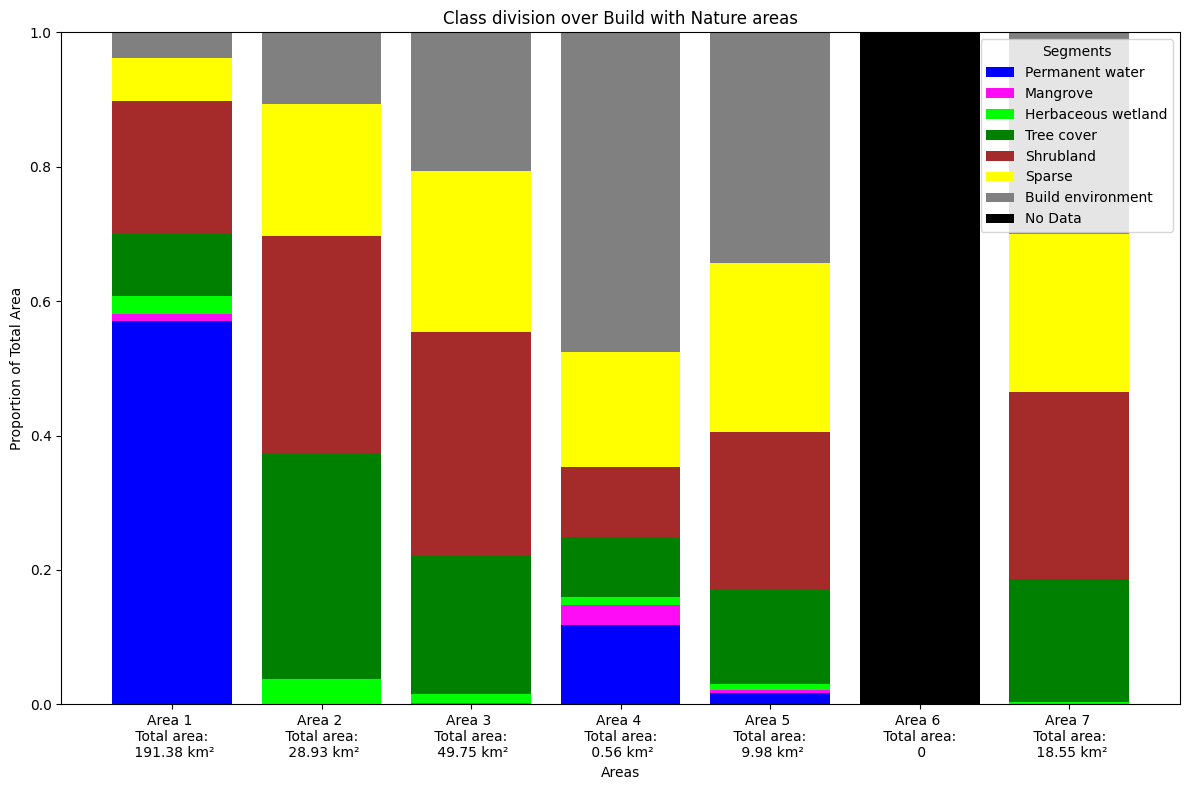

In [20]:
# Calculating values for Build with Nature policy
m = geemap.Map()
ropv1 = ee.FeatureCollection('projects/ee-mooscastelijn/assets/ropv1')
ropv2 = ee.FeatureCollection('projects/ee-mooscastelijn/assets/ropv2')
ropv = ropv1.merge(ropv2)

ROPVCategories = [
    "Bedrijventerrein Barcadera",
    "Bedrijventerrein San Nicolas",
    "Centrum Oranjestad",
    "Centrum San Nicolas",
    "Havenfront Oranjestad",
    "Landelijk gebied",
    "Luchthaven",
    "Marine park",
    "Marinezones",
    "Natuur en landschap",
    "Natuurgebied",
    "Stedelijk woongebied",
    "Strand",
    "Toeristisch gebied westkust",
    "Toeristische zone oostkust",
    "Transformatiegebied",
    "Woongebied met waarden"
]

# Welke er missen uit het bijlage B: Industriegebied, Infrastructuur, Hoofdwegen, Oranjestad.
ROPVCatToFigure = {
    0: [10, 9, 12, 7, 8],
    1: [5],
    2: [16],
    3: [4, 13, 14],
    4: [6, 0, 1],
    5: [],
    6: [11, 2, 3, 15]
}

# Segment names
segment_names = [
    'Permanent water',
    'Mangrove',
    'Herbaceous wetland',
    'Tree cover',
    'Shrubland',
    'Sparse',
    'Build environment',
    'No Data'
]

classPalette = [
  '#0000FF', # Permanent Water: Blue
  '#ff0cf6', # Mangroves: Purple
  '#00FF00', # Herbaceous wetland: Bright Green
  '#008000', # Tree Cover: Dark Green
  '#A52A2A', # Shrubland: Brown
  '#FFFF00', # Bare or sparse vegetation: Yellow
  '#808080', # Built environment: Grey
  '#000000', # No data: Black 
]

imageDate = '2024-07'
i = 0
res = 30
classImage = ee.Image(f'projects/aruba-tdf/assets/classImages/{imageDate}')
ROPVRegionAreas = {region: [] for region in ROPVCatToFigure.keys()}

for ROPVZone, ROPVAreas in ROPVCatToFigure.items():
    legendaValues = [ROPVCategory for i, ROPVCategory in enumerate(ROPVCategories) if i in ROPVAreas]
    if len(legendaValues) > 0:
        filteredFeatures = ropv.filter(ee.Filter.inList('Legenda', legendaValues))
        mask = ee.Image.constant(1).clip(filteredFeatures.geometry())
        
        maskedToRegion = classImage.mask(mask)
        areaRegion = maskedToRegion.reduceRegion(reducer= ee.Reducer.count(), geometry= maskedToRegion.geometry(), scale= res)
        ROPVRegionAreas[ROPVZone].append(areaRegion.getInfo()['classification'])
        m.addLayer(maskedToRegion)

        for className in classNames:
            RegionToClassMasked = maskedToRegion.updateMask(maskedToRegion.select('classification').eq(classNames.index(className)))
            areaDict = RegionToClassMasked.reduceRegion(
                reducer=ee.Reducer.count(), geometry=RegionToClassMasked.geometry(), 
                scale=res, maxPixels=1e20)
            area = areaDict.getInfo()['classification']
            ROPVRegionAreas[ROPVZone].append(area)
            print(className, area)
    else:
        ROPVRegionAreas[ROPVZone].append(0)
        for className in classNames:
            ROPVRegionAreas[ROPVZone].append(0)

# Formatting labels
x = [
    f'Area 1 \n Total area: \n {round(ROPVRegionAreas[0][0]*res**2/1000000, 2)} km²', 
    f'Area 2 \n Total area: \n {round(ROPVRegionAreas[1][0]*res**2/1000000, 2)} km²', 
    f'Area 3 \n Total area: \n {round(ROPVRegionAreas[2][0]*res**2/1000000, 2)} km²', 
    f'Area 4 \n Total area: \n {round(ROPVRegionAreas[3][0]*res**2/1000000, 2)} km²', 
    f'Area 5 \n Total area: \n {round(ROPVRegionAreas[4][0]*res**2/1000000, 2)} km²', 
    f'Area 6 \n Total area: \n {0}',
    f'Area 7 \n Total area: \n {round(ROPVRegionAreas[6][0]*res**2/1000000, 2)} km²'
]

# Normalize data based on the first value in each list
normalizedData = {}
for key, values in ROPVRegionAreas.items():
    if values[0] != 0:  # Avoid division by zero
        total = values[0]
        normalizedData[key] = [v / total for v in values]
    else:
        normalizedData[key] = [0 for v in values]

# Split normalized data for stacked bar plot
splitInYs = {f'y{i}': [] for i in range(len(ROPVRegionAreas[0]))}
for areaNumber, areas in normalizedData.items():
    for i, area in enumerate(areas):  # Include the first value (total area)
        splitInYs[f'y{i}'].append(area)

splitInYs['y8'] = [0, 0, 0, 0, 0, 1, 0]
print(splitInYs)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Stack the bars
bottom = np.zeros(len(x))
for i in range(1, len(ROPVRegionAreas[0])+1):  # Skip the first value (total area)
    ax.bar(x, splitInYs[f'y{i}'], bottom=bottom, label=segment_names[i-1], color=classPalette[i-1])
    bottom += splitInYs[f'y{i}']

# Add labels and title
ax.set_xlabel('Areas')
ax.set_ylabel('Proportion of Total Area')
ax.set_title(f'Class division over Build with Nature areas')
ax.legend(title='Segments')

plt.tight_layout()
plt.savefig(imageDate)

In [59]:
import pandas as pd
import numpy as np

# first is total area, rest are partial areas, within the zones
percentages = {key: np.round(np.array(value)*100, 2) for (key, value) in splitInYs.items()}

df1 = pd.DataFrame.from_dict(percentages, orient='index')
df1.index = classNames
df1.columns = [f'Area {i}' for i in range(1, 8)]

ROPVRegionOnlyAreas = {key: value[1:] for key, value in ROPVRegionAreas.items()}

df2 = pd.DataFrame(ROPVRegionOnlyAreas)
df2.index = classNames
df2.columns = [f'Area {i}' for i in range(1, 8)]

df = df2.astype(str) + ' (' + df1.astype(str) + ')'

output_file = './output/buildWithNature.xlsx'
df.to_excel(output_file, sheet_name='Environmental Data') 

                    Area 1  Area 2  Area 3  Area 4  Area 5  Area 6  Area 7
Permanent_Water      57.05    0.02    0.05   11.86    1.71     0.0    0.03
Mangrove              0.97    0.01    0.09    2.88    0.41     0.0    0.01
Herbaceous_Wetland    2.78    3.70    1.34    1.28    0.86     0.0    0.25
Tree_Cover            9.21   33.59   20.54    8.81   14.06     0.0   18.30
Shrubland            19.72   32.39   33.35   10.42   23.53     0.0   27.88
Sparse                6.38   19.70   23.99   17.15   25.09     0.0   23.49
Build_Environment     3.88   10.60   20.64   47.60   34.35     0.0   30.05
                    Area 1  Area 2  Area 3  Area 4  Area 5  Area 6  Area 7
Permanent_Water     121322       5      28      74     190       0       6
Mangrove              2069       3      51      18      45       0       2
Herbaceous_Wetland    5910    1188     741       8      95       0      52
Tree_Cover           19592   10798   11352      55    1559       0    3772
Shrubland            4193

In [12]:
# Visualizing SDG 15.1.1
m = geemap.Map()
imageDate = '2024-07'
classImage = ee.Image(f'projects/aruba-tdf/assets/classImages/{imageDate}')
subClassImage = ee.Image(f'projects/aruba-tdf/assets/subClassImages/{imageDate}_Tree_Cover')

visM = {
    'color': '#ff0cf6'  # Pink color
}

visC = {'color': '#A52A2A' }

visT = {
    'color': '#013220'  # Dark green and red-brown
}

mangrove = classImage.updateMask(classImage.eq(1))
vMangrove = mangrove.addBands(mangrove).reduceToVectors(
            geometry=crudeBorders,
            crs=subClassImage.projection(),
            scale=30,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )
vMangroveLargePolygons = vMangrove.map(lambda feature: feature.set({'area': feature.geometry().area(10)}))
vMangroveLargePolygons = vMangroveLargePolygons.filter(ee.Filter.gt('area', 5000))

cactus = subClassImage.updateMask(subClassImage.eq(0))
vCactus = cactus.addBands(cactus).reduceToVectors(
            geometry=crudeBorders,
            crs=subClassImage.projection(),
            scale=30,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )
vCactusLargePolygons = vCactus.map(lambda feature: feature.set({'area': feature.geometry().area(10)}))
vCactusLargePolygons = vCactusLargePolygons.filter(ee.Filter.gt('area', 5000))

tree = subClassImage.updateMask(subClassImage.eq(1))
vTree = tree.addBands(tree).reduceToVectors(
            geometry=crudeBorders,
            crs=subClassImage.projection(),
            scale=30,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )
vTreeLargePolygons = vTree.map(lambda feature: feature.set({'area': feature.geometry().area(10)}))
vTreeLargePolygons = vTreeLargePolygons.filter(ee.Filter.gt('area', 5000))

m.addLayer(vMangroveLargePolygons, visM, 'mangrove')
m.addLayer(vCactusLargePolygons, visC, 'cactus')
m.addLayer(vTreeLargePolygons, visT, 'treeCover')
m.centerObject(vMangrove, 10)

m

Map(center=[12.501636759510681, -69.98930757363141], controls=(WidgetControl(options=['position', 'transparent…

In [11]:
# Visualizing SDG 15.3.1
imageDate = '2024-07'
buildImage = ee.Image(f'projects/aruba-tdf/assets/subClassImages/{imageDate}_Build_Environment')
bareImage = ee.Image(f'projects/aruba-tdf/assets/subClassImages/{imageDate}_Sparse')
m = geemap.Map()

# Subclasses: Quarry, Degraded_Land, Dead_Mangrove, Sportfields
quarry = bareImage.updateMask(bareImage.eq(0))
degrad = bareImage.updateMask(bareImage.eq(1))
dead = bareImage.updateMask(bareImage.eq(5))
sportfield = buildImage.updateMask(buildImage.eq(2))

vQuarry = quarry.addBands(quarry).reduceToVectors(
            geometry=crudeBorders,
            crs=bareImage.projection(),
            scale=30,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )

vDegrad = degrad.addBands(degrad).reduceToVectors(
            geometry=crudeBorders,
            crs=bareImage.projection(),
            scale=30,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )

vDead = dead.addBands(dead).reduceToVectors(
            geometry=crudeBorders,
            crs=bareImage.projection(),
            scale=30,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )

vSportfield = sportfield.addBands(sportfield).reduceToVectors(
            geometry=crudeBorders,
            crs=bareImage.projection(),
            scale=30,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='landcover',
            reducer=ee.Reducer.mean()
        )

visQ = {'color': '#595959' }
visDeg = {'color': 'brown'}
visDea = {'color': '#A9A9A9'}
visS= {'color': '#8B8000'}

m.addLayer(vQuarry, visQ, 'quarry')
m.addLayer(vDegrad, visDeg, 'Degraded')
m.addLayer(vDead, visDea, 'Dead mangrove')
m.addLayer(vSportfield, visS, 'Sportfield')
m.centerObject(bareImage, 10)
m

Map(center=[12.515739178941121, -69.96227655677109], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# visualizing A.2
# Classes: Sea, Mangroves, Herbacious Wetland, Tree Cover, Shrubland
# Subclasses: Sandcoast, Rockycoast, Rockformations

# Subclasses: Quarry, Degraded_Land, Dead_Mangrove, Sportfields
plt.plot(dates, quarriesAverages, label='Quarries', color='#595959')
plt.plot(dates, degradAverages, label='Degraded Land (UTV)', color='brown')
plt.plot(dates, deadMangroveAverages, label='Dead Mangroves', color='#D3D3D3')
plt.plot(dates, sportfield, label='Sportfields', color='#8B8000')
